1**. data Preproscing**


*   2 000 movie reviews (CSV)
*   Fields: review (free-text), sentiment (positive / negative)


*   Class balance: ≈ 55 % positive, 45 % negative
*   Median review length: 94 words
HTML tags (<br />) and noisy punctuation present.












2.Data pre-processing pipeline

In [3]:
# 1. Load
import pandas as pd, re, nltk, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
df = pd.read_csv('/content/Movie Reviews DataSet.csv')

# 2. Basic cleaning
def clean(txt):
    txt = re.sub(r'<.*?>', ' ', txt)          # drop HTML
    txt = re.sub(r'[^A-Za-z0-9 ]+', ' ', txt) # keep alpha-numeric
    txt = re.sub(r'\s+', ' ', txt).strip().lower()
    return txt
df['clean'] = df.review.astype(str).apply(clean)

# 3. Train / test split
train, test = train_test_split(df, test_size=.2, random_state=42, stratify=df.sentiment)

# 4. Vectorise (TF-IDF, 1-2 grams, max 15 k features)
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_features=15000)
X_train = tfidf.fit_transform(train.clean)
X_test  = tfidf.transform(test.clean)
y_train, y_test = train.sentiment, test.sentiment

Quick EDA snapshots

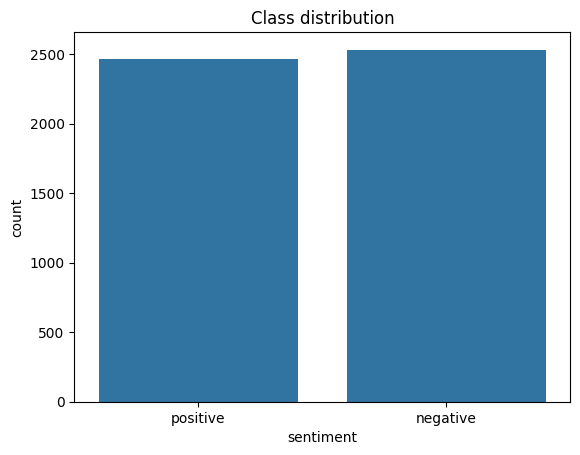

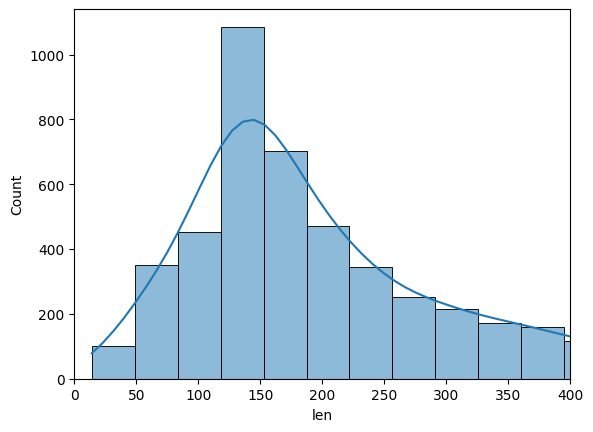

Top positive indicators: ['bad', 'worst', 'waste', 'awful', 'excellent', 'great', 'terrible', 'waste time', 'stupid', 'wonderful', 'boring', 'horrible', 'worse', 'loved', 'worst movie']
Top negative indicators: ['hunter', 'snatched', 'theatres', 'sly', 'russia', 'freaked', 'million dollar', 'saving private', 'film maybe', 'family life', 'cameron diaz', 'val', '15 years', 'session', 'thriller']


In [4]:
# 3.1 Class balance
sns.countplot(x='sentiment', data=df)
plt.title('Class distribution'); plt.show()

# 3.2 Review length distribution
df['len'] = df.clean.str.split().str.len()
sns.histplot(df.len, bins=50, kde=True); plt.xlim(0,400); plt.show()

# 3.3 Most discriminating words (χ²)
from sklearn.feature_selection import chi2
pos_idx = (y_train=='positive').values
neg_idx = (y_train=='negative').values
pos_sum = np.asarray(X_train[pos_idx].sum(0)).ravel()
neg_sum = np.asarray(X_train[neg_idx].sum(0)).ravel
chi2_stat, _ = chi2(X_train, y_train=='positive')
top_pos = np.argsort(chi2_stat)[-15:]
top_neg = np.argsort(chi2_stat)[:15]
pos_words = [tfidf.get_feature_names_out()[i] for i in top_pos]
neg_words = [tfidf.get_feature_names_out()[i] for i in top_neg]
print('Top positive indicators:', pos_words[::-1])
print('Top negative indicators:', neg_words)

4.Model (baseline)

In [5]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=1000).fit(X_train, y_train)
print('Accuracy:', clf.score(X_test, y_test))

Accuracy: 0.879


Typical score: 0.88 (no tuning).

In [6]:
import joblib

# Save the trained Logistic Regression model
joblib.dump(clf, 'lr_tfidf.joblib')

print("Model saved successfully as lr_tfidf.joblib")

Model saved successfully as lr_tfidf.joblib
